In [133]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import requests, censusdata, zipfile
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## 1. US county demographic data EDA
####  1.1 Set raw and processed data directories

In [14]:
raw_dir = Path('../raw_data/')
processed_dir = Path('../processed_data/')

assert(raw_dir.exists() & processed_dir.exists()), 'data directories not valid'

#### 1.2 Pull downloaded Kaggle data (requires auth) 
Basic county-level demographic data from JHU and US Census was downloaded from Kaggle to a CSV since download requires username / password authentication. The data contains the unique FIPS code, county / state names, male and female populations, median county age, as well as the latitude and longitude of the center of the county.

In [5]:
kaggle_demos = pd.read_csv(raw_dir/'us_county.csv')
kaggle_demos.head()

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long
0,1001,Autauga County,Alabama,AL,26874,28326,37.8,55200,51.315217,32.534923,-86.642730
1,1003,Baldwin County,Alabama,AL,101188,106919,42.8,208107,51.376936,30.727479,-87.722564
2,1005,Barbour County,Alabama,AL,13697,12085,39.9,25782,46.873788,31.869581,-85.393210
3,1007,Bibb County,Alabama,AL,12152,10375,39.9,22527,46.055844,32.998628,-87.126475
4,1009,Blount County,Alabama,AL,28434,29211,40.8,57645,50.673953,33.980869,-86.567380


#### 1.3 Request IHME health data

Some additional health data was downloaded from the Institute for Health Metrics and Evaluation (IHME). The data contains time series records of mortality risk and life expectancy measures across every county for several age ranges dating back to the 1980s. We cleaned and standardized this data to only include the most recent sample of county average life expectancy at birth and mortality risk for the 65 to 85 year old population (the most vulnerable to the effects of COVID-19). The data also includes a FIPS code.

In [6]:
if 'ihme_health.csv' not in [_.name for _ in raw_dir.glob('*')]:
    h_url = 'http://ghdx.healthdata.org/sites/default/files/record-attached-files/'
    h_file = 'IHME_USA_COUNTY_LE_MORTALITY_RISK_1980_2014_NATIONAL_STATES_DC_CSV.zip'
    r = requests.get(h_url+h_file, stream=True)
    with open(raw_dir/'ihme_health.zip', 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
    with zipfile.ZipFile(raw_dir/'ihme_health.zip', 'r') as zip_ref:
        zip_ref.extractall(raw_dir/'imhe_health/')
    health_pth = Path(raw_dir/'imhe_health/')
    assert health_pth.exists(), 'no health files found'
    files = health_pth.glob('*.csv')
    
    health_dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            max_year = df.year_id.max()
            # logic to get single rows for pivot table
            df = df[(df.year_id == max_year) & (df.sex == "Both") \
                    & ((df.age_name == "0") | (df.age_name == "65 to 85"))]
            pvt = pd.pivot_table(df, values = 'val', columns = 'measure_name',
                    index=['FIPS', 'location_name']).reset_index()
            health_dfs.append(pvt)
        except Exception as e:
            print(e); continue
            
    health = pd.concat([_ for _ in health_dfs if _.shape[0] > 1])
    health.to_csv(raw_dir/'ihme_health.csv')
else:
    health = pd.read_csv(raw_dir/'ihme_health.csv')

'>=' not supported between instances of 'str' and 'float'


In [7]:
health.head()

measure_name,FIPS,location_name,Life expectancy,Mortality risk
0,1,Alabama,75.648292,57.460523
1,1001,Autauga County,75.668023,58.373616
2,1003,Baldwin County,78.075681,50.486669
3,1005,Barbour County,75.421683,56.251879
4,1007,Bibb County,73.967404,61.110046


#### 1.4 Census income data

We downloaded county-level income data from the most recent Census survey (2018) and processed the data to find the estimated number of impoverished people in each county, as well as the median household income. The data again includes a FIPS code.

In [55]:
r = requests.get('https://www2.census.gov/programs-surveys/saipe/datasets/2016/2016-state-and-county/est16all.txt')
t = r.text

lines = t.split('\n')
income_dict = {}
for l in lines:
    name = l[193:238].strip()
    if name == '': continue
    fin_demos = {
        'fips_state': l[0:2].strip(),
        'fips_county': l[3:6].strip(),
        'all_poverty': l[7:15].strip(),
        'median_hh_income': l[133:139].strip()
    }
    income_dict[name] = fin_demos

income = pd.DataFrame(income_dict).T
def fix_fips(s):
    if len(s) == 3: return s
    elif len(s) == 2: return f'0{s}'
    else: return f'00{s}'
    
# fix erros in Kalawao county
income = income.replace('.', np.nan)
income['all_poverty'] = income.all_poverty.astype(float)
income['median_hh_income'] = income.median_hh_income.astype(float)

income['fips_county_pad'] = income.fips_county.map(fix_fips)
income['fips'] = (income.fips_state + income.fips_county_pad).astype(int)
income.head()

,fips_state,fips_county,all_poverty,median_hh_income,fips_county_pad,fips
United States,00,0,44268996.0,57617.0,000,0
Alabama,01,0,814197.0,46309.0,000,1000
Autauga County,01,1,7444.0,54487.0,001,1001
Baldwin County,13,9,10273.0,40683.0,009,13009
Barbour County,54,1,3514.0,36485.0,001,54001


#### 1.5 Land area

Finally, we pull census data for the land area (in square miles) of each county as of 2010, which is the most recent year available. The data includes the FIPS code.

In [26]:
landvar = 'LND110210D'
land = pd.read_csv(raw_dir/'LND01.csv')[['STCOU', landvar]].rename(
    columns={'STCOU':'fips', landvar:'sq_miles'})
land.head()

,fips,sq_miles
0,0,3531905.43
1,1000,50645.33
2,1001,594.44
3,1003,1589.78
4,1005,884.88


#### 1.6 Merge

We merge all of these datasets on FIPS code.

In [66]:
demos = pd.merge(
    kaggle_demos, health.set_index('FIPS')[['Life expectancy', 'Mortality risk']],
    left_on='fips', right_index=True).merge(
        income.set_index('fips')[['all_poverty', 'median_hh_income']],
        left_on='fips', right_index=True).merge(
            land.set_index('fips'), left_on='fips', right_index=True)

def fix_colname(s): return s.lower().strip().replace(' ', '_')
demos.columns = [fix_colname(_) for _ in demos.columns]
demos.head()

,fips,county,state,state_code,male,female,median_age,population,female_percentage,lat,long,life_expectancy,mortality_risk,all_poverty,median_hh_income,sq_miles
0,1001,Autauga County,Alabama,AL,26874,28326,37.8,55200,51.315217,32.534923,-86.642730,75.668023,58.373616,7444.0,54487.0,594.44
5,1011,Bullock County,Alabama,AL,5663,4689,39.6,10352,45.295595,32.100525,-85.715679,73.859057,56.831543,2841.0,34278.0,622.81
10,1021,Chilton County,Alabama,AL,21672,22258,38.6,43930,50.666970,32.847867,-86.718790,74.527386,59.625260,7960.0,44188.0,692.85
16,1033,Colbert County,Alabama,AL,26075,28420,42.7,54495,52.151574,34.700471,-87.804928,75.071790,58.774889,8982.0,46572.0,592.62
17,1035,Conecuh County,Alabama,AL,6037,6477,44.8,12514,51.758031,31.429237,-86.993662,74.050503,56.796792,3464.0,29758.0,850.16


#### 1.7 Enrich

We engineer two features that we intuitively believe may have some relationship to the spread of COVID-19. The first is related to the rate at which the population is impoverished. We have estimates from Census of the total number of inhabitants living below the poverty line, but here we standardize by the population of the county to arrive at an estimate of the percent of the county that is impoverished. We also use the population variable and the estimated land area variable to determine the population density in terms of inhabitants per square mile.

Save the data to the processed data directory for use in modeling.

In [68]:
demos['pct_impoverished'] = demos.all_poverty.div(demos.population)
demos['pop_density'] = demos.population.div(demos.sq_miles)

In [69]:
demos.to_csv(processed_dir/'demographic_data.csv', index=False)

## 2. Data understanding
We'll visualize some key features to get a better understanding of the demographic data.

In [77]:
features = 'median_age female_percentage life_expectancy mortality_risk \
median_hh_income pct_impoverished pop_density'.split()

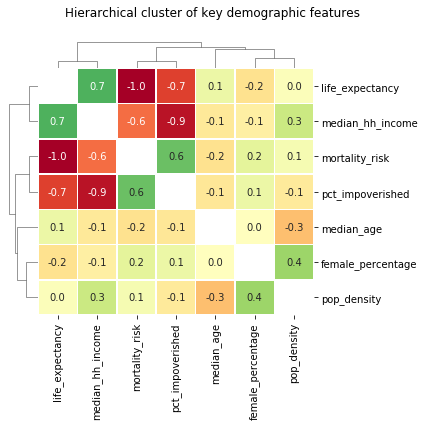

In [116]:
cm = sns.clustermap(demos[features].corr(method='spearman'), annot=True, fmt='.1f', linewidths=0.5,
              mask=np.eye(len(features)), cmap='RdYlGn', dendrogram_ratio=.1,
              figsize=(6,6), cbar=False)
cm.fig.subplots_adjust(top=.9)
cm.cax.set_visible(False)
cm.fig.suptitle('Hierarchical cluster of key demographic features')
plt.show()

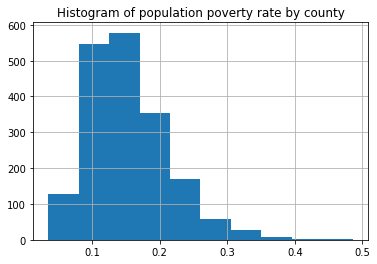

In [132]:
demos.pct_impoverished.hist()
plt.title('Histogram of population poverty rate by county')
plt.show()

R2 score of poverty and mortality risk is 0.322


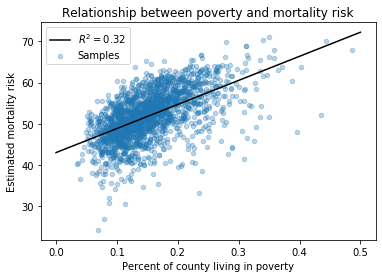

In [145]:
demos.plot.scatter('pct_impoverished', 'mortality_risk', alpha=0.3)
plt.xlabel('Percent of county living in poverty')
plt.ylabel('Estimated mortality risk')
plt.title('Relationship between poverty and mortality risk')

X = demos.dropna()
lm = LinearRegression().fit(X.pct_impoverished.values.reshape(-1,1), X.mortality_risk)
xs = np.linspace(0, 0.5)
ys = lm.predict(xs.reshape(-1,1))
r2 = lm.score(X.pct_impoverished.values.reshape(-1,1), X.mortality_risk)
print(f"R2 score of poverty and mortality risk is {r2:.3f}")
plt.plot(xs,ys, color='black')
plt.legend([f'$R^2 = {r2:.2f}$', 'Samples'])
plt.show()

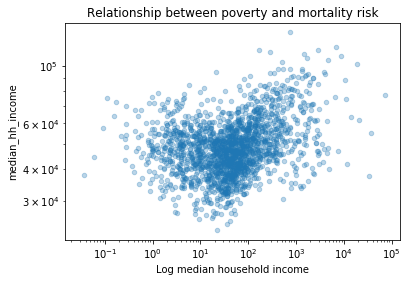

In [130]:
demos.plot.scatter('pop_density', 'median_hh_income', alpha=0.3)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('Log population density')
plt.xlabel('Log median household income')
plt.title('Relationship between poverty and mortality risk'); plt.show()